In [92]:
import pandas as pd 
import numpy as np

file_path = r"D:\Box Sync\00_BEAR_Lab\Projects\Kyler(Kihun) Hong\2nd_Braille Display\Final Participant Data\AB Participants\03262024_ABParticipant 5\ABParticipant5_NB\Trajectory\NB_1.5mm0.75mm_SL1M2.csv"
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Step 2: Skip first 4 rows (metadata rows) and treat row 5 as column header
df = pd.read_csv(file_path, skiprows=3, header=0)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.reset_index(drop=True)
extracted_df=df.iloc[3:,1:]

rigidbody016_cols = [col for col in extracted_df.columns if 'RigidBody 016' in col or 'RigidBody016' in col]
df_rigidbody016 = extracted_df[rigidbody016_cols].copy()

# Optional: reset index and show preview
df_rigidbody016 = df_rigidbody016.reset_index(drop=True)
print("✅ Extracted RigidBody016 data:")
print(df_rigidbody016.head())

xyz_cols = [col for col in df_rigidbody016.columns if 'RigidBody 016.4' in col or 'RigidBody 016.6' in col]
df_rigidbody016_xyz = df_rigidbody016[xyz_cols]

df_rigidbody016_xyz.rename(columns={
    'RigidBody 016.4': 'Head_X',
    'RigidBody 016.6': 'Head_Y'
}, inplace=True)

df_rigidbody016_xyz
extracted_headxy = df_rigidbody016_xyz[['Head_X', 'Head_Y']].copy()
extracted_headxy = extracted_headxy.dropna().reset_index(drop=True)
observations = extracted_headxy.values

n_timesteps = len(observations)
x_est = np.zeros((n_timesteps, 2))  # estimated states

# Initial state estimate (first observed point)
x = observations[0]

# Initial error covariance matrix
P = np.eye(2)

# State transition matrix (assume constant position for simplicity)
F = np.eye(2)

# Observation matrix
H = np.eye(2)

# Observation noise covariance
R = np.array([[0.05, 0], [0, 0.05]])  # assume small measurement noise

# Process noise covariance
Q = np.array([[0.01, 0], [0, 0.01]])  # assume small process noise

# Kalman Filter loop
for t in range(n_timesteps):
    z = observations[t]

    # Predict
    x = F @ x
    P = F @ P @ F.T + Q

    # Update
    y = z - H @ x
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    x = x + K @ y
    P = (np.eye(2) - K @ H) @ P

    x_est[t] = x

# Add to DataFrame
extracted_headxy[['Kalman_X', 'Kalman_Y']] = x_est

# ✅ Preview filtered results
print(extracted_headxy.head())


✅ Extracted RigidBody016 data:
   RigidBody 016  RigidBody 016.1  RigidBody 016.2  RigidBody 016.3  \
0      -0.090932        -0.137926        -0.153618         0.974222   
1      -0.091146        -0.137819        -0.153727         0.974200   
2      -0.094096        -0.138129        -0.156340         0.973460   
3      -0.093973        -0.138140        -0.156290         0.973478   
4      -0.112142        -0.132645        -0.161281         0.971503   

   RigidBody 016.4  RigidBody 016.5  RigidBody 016.6  RigidBody 016.7  \
0        -1.723013         1.645069         0.058958         0.002160   
1        -1.723020         1.645029         0.058958         0.002150   
2        -1.722362         1.644981         0.058879         0.001322   
3        -1.722348         1.644978         0.058846         0.001328   
4        -1.721954         1.645456         0.059403         0.001117   

   RigidBody 016:Marker1  RigidBody 016:Marker1.1  RigidBody 016:Marker1.2  \
0              -1.654657 

C:\Users\Kihun\AppData\Local\Temp\ipykernel_2816\1996293539.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rigidbody016_xyz.rename(columns={


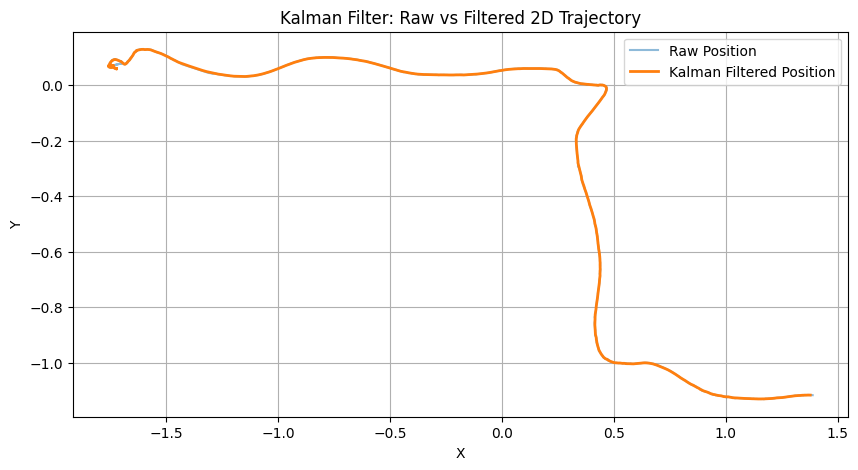

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(extracted_headxy['Head_X'], extracted_headxy['Head_Y'], label='Raw Position', alpha=0.5)
plt.plot(extracted_headxy['Kalman_X'], extracted_headxy['Kalman_Y'], label='Kalman Filtered Position', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kalman Filter: Raw vs Filtered 2D Trajectory')
plt.legend()
plt.grid(True)
plt.show()
